# Task 2 : Experimentation and uplift testing

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.
To get started, use the QVI_data dataset below or your output from task 1 and consider the monthly sales experience of each store. 

This can be broken down by:

- total sales revenue
- total number of customers
- average number of transactions per customer

Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

In [1]:
#IMPORT THE LIBRARY
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import xlrd
import re

#   Ignoring any warnings.

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Load the Dataset

In [2]:
df = pd.read_csv('QVI_data.csv')

In [3]:
df.head(2)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream


In [4]:
df.tail(2)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget
264833,2373711,2018-12-14,88,241815,16,Smiths Crinkle Chips Salt & Vinegar 330g,2,11.4,330,SMITHS,YOUNG SINGLES/COUPLES,Mainstream


In [5]:
df.columns

Index(['LYLTY_CARD_NBR', 'DATE', 'STORE_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'PACK_SIZE', 'BRAND', 'LIFESTAGE',
       'PREMIUM_CUSTOMER'],
      dtype='object')

### Descriptive Analytics: Summary statistics, visualizations

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [7]:
df.isna().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

- We need to convert DATE column from object to Datetime datatype.

In [8]:
df['DATE'] = pd.to_datetime(df['DATE'])

### Extracting `YEAR` & `MONTH` from `DATE` column.

In [9]:
df['MONTH'] = df['DATE'].dt.month
df['YEAR'] = df['DATE'].dt.year
df['MONTH-YEAR'] = df['DATE'].dt.to_period('M')

In [10]:
df.drop('MONTH', axis = 1, inplace = True)

## Metrics

### Average Sales and Product Quantity

In [11]:
store_metrics = df.groupby('STORE_NBR').agg({'TOT_SALES': 'mean','PROD_QTY': 'mean'}).reset_index()
store_metrics.head()

,STORE_NBR,TOT_SALES,PROD_QTY
0,1,4.177312,1.228621
1,2,3.964032,1.114625
2,3,8.523602,1.940746
3,4,8.729231,1.976162
4,5,6.980749,1.986774


### Total Sales by Store Number

In [12]:
total_sales = df.groupby(["STORE_NBR", "MONTH-YEAR"])["TOT_SALES"].sum().to_frame() 
total_sales

TOT_SALES
STORE_NBR MONTH-YEAR           
1         2018-07         206.9
          2018-08         176.1
          2018-09         278.8
          2018-10         188.1
          2018-11         192.6
...                         ...
272       2019-02         395.5
          2019-03         442.3
          2019-04         445.1
          2019-05         314.6
          2019-06         312.1

[3169 rows x 1 columns]

we can also count the number of unique customers for each month for each store by `LYLTY_CARD_NBR`.

### Total Unique Customers by Store Number

In [13]:
total_customers = df.groupby(["STORE_NBR", "MONTH-YEAR"])["LYLTY_CARD_NBR"].nunique().to_frame()   
total_customers

LYLTY_CARD_NBR
STORE_NBR MONTH-YEAR                
1         2018-07                 49
          2018-08                 42
          2018-09                 59
          2018-10                 44
          2018-11                 46
...                              ...
272       2019-02                 45
          2019-03                 50
          2019-04                 54
          2019-05                 34
          2019-06                 34

[3169 rows x 1 columns]

### Total Unique Transactions by Store Number

In [14]:
total_transactions = df.groupby(["STORE_NBR", "MONTH-YEAR"])["TXN_ID"].nunique().to_frame()
total_transactions

TXN_ID
STORE_NBR MONTH-YEAR        
1         2018-07         52
          2018-08         43
          2018-09         62
          2018-10         45
          2018-11         47
...                      ...
272       2019-02         48
          2019-03         53
          2019-04         55
          2019-05         40
          2019-06         37

[3169 rows x 1 columns]

Now, We can find the number of transactions per customer by diving the count of the number of unique transactions and the count of the number of unique customers for each store.

In [15]:
transactions_per_customer = df.groupby(["STORE_NBR", "MONTH-YEAR"])["TXN_ID"].nunique()/df.groupby(["STORE_NBR", "MONTH-YEAR"])["LYLTY_CARD_NBR"].nunique()   #   Grouping the pandas.DataFrame by the STORE_NBR and YEAR_MONTH column, and counting the unique number of transactions per customer for them.
transactions_per_customer = transactions_per_customer.to_frame()  #   Converting the pandas.Series to a pandas.DataFrame.
transactions_per_customer

0
STORE_NBR MONTH-YEAR          
1         2018-07     1.061224
          2018-08     1.023810
          2018-09     1.050847
          2018-10     1.022727
          2018-11     1.021739
...                        ...
272       2019-02     1.066667
          2019-03     1.060000
          2019-04     1.018519
          2019-05     1.176471
          2019-06     1.088235

[3169 rows x 1 columns]

### Creating a Metrics Combining `total_sales`, `total_customers`,`transactions_per_customer`

In [16]:
list = [total_sales, total_customers, transactions_per_customer] 
df_metrics = pd.concat(list, axis=1)
df_metrics.columns=["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"]
df_metrics

TOT_SALES  TOT_CUST  TXN_PER_CUST
STORE_NBR MONTH-YEAR                                   
1         2018-07         206.9        49      1.061224
          2018-08         176.1        42      1.023810
          2018-09         278.8        59      1.050847
          2018-10         188.1        44      1.022727
          2018-11         192.6        46      1.021739
...                         ...       ...           ...
272       2019-02         395.5        45      1.066667
          2019-03         442.3        50      1.060000
          2019-04         445.1        54      1.018519
          2019-05         314.6        34      1.176471
          2019-06         312.1        34      1.088235

[3169 rows x 3 columns]

In [17]:
df_metrics.isnull().sum()

TOT_SALES       0
TOT_CUST        0
TXN_PER_CUST    0
dtype: int64

Since the dataset contains transaction details of many stores, there may be some stores that did not record sales for the entire duration.

In [18]:
recorded_stores = pd.pivot_table(df, index="STORE_NBR", columns="MONTH-YEAR", values="TXN_ID", aggfunc="count") #   Pivoting the pandas.DataFrame to get all the recorded transactions for each store during the entire duration.
recorded_stores

MONTH-YEAR,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [19]:
recorded_stores.isnull().sum()

MONTH-YEAR
2018-07    6
2018-08    9
2018-09    8
2018-10    7
2018-11    8
2018-12    9
2019-01    9
2019-02    8
2019-03    7
2019-04    7
2019-05    9
2019-06    8
Freq: M, dtype: int64

As we can see, there are null values for a few months, which means that some of these are unrecorded for certain stores, so we need to find them and remove these stores from the dataset, since they can't be control stores anyway.

In [20]:
unrecorded_stores=[]
for i in recorded_stores.index:
    if recorded_stores.loc[i].isnull().any():
        unrecorded_stores.append(i)
unrecorded_stores

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [21]:
df_metrics = df_metrics.drop(unrecorded_stores, axis=0)
df_metrics

TOT_SALES  TOT_CUST  TXN_PER_CUST
STORE_NBR MONTH-YEAR                                   
1         2018-07         206.9        49      1.061224
          2018-08         176.1        42      1.023810
          2018-09         278.8        59      1.050847
          2018-10         188.1        44      1.022727
          2018-11         192.6        46      1.021739
...                         ...       ...           ...
272       2019-02         395.5        45      1.066667
          2019-03         442.3        50      1.060000
          2019-04         445.1        54      1.018519
          2019-05         314.6        34      1.176471
          2019-06         312.1        34      1.088235

[3120 rows x 3 columns]

We can filter the dataset to the pre-trial duration — that is, before February 2019.

In [22]:
pre_trial_data = df_metrics.loc[df_metrics.index.get_level_values("MONTH-YEAR")<"2019-02"]  #   Extracting the pandas.DataFrame for the pre-trial duration.
pre_trial_data = pre_trial_data.reset_index()
pre_trial_data

,STORE_NBR,MONTH-YEAR,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,1,2018-07,206.9,49,1.061224
1,1,2018-08,176.1,42,1.023810
2,1,2018-09,278.8,59,1.050847
3,1,2018-10,188.1,44,1.022727
4,1,2018-11,192.6,46,1.021739
...,...,...,...,...,...
1815,272,2018-09,304.7,32,1.125000
1816,272,2018-10,430.6,44,1.136364
1817,272,2018-11,376.2,41,1.097561
1818,272,2018-12,403.9,47,1.000000


From the pre-trial dataset, we can now filter the control stores, which are the ones that do not include STORE_NBR 77, 88, and 89.

In [23]:
control_stores = pre_trial_data[(pre_trial_data.STORE_NBR!=77 ) & (pre_trial_data.STORE_NBR!=86) & (pre_trial_data.STORE_NBR!=88)][["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"]].groupby(pre_trial_data.STORE_NBR).sum()
control_stores

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
1,1386.90,317,7.327967
2,1128.50,272,7.359700
3,7526.15,744,8.209829
4,9127.00,849,8.535253
5,5739.70,651,8.791906
...,...,...,...
268,1549.05,304,7.373037
269,6664.50,746,8.921035
270,6697.95,734,9.147187


Likewise, we can also filter the trial stores from the dataset.

In [24]:
trial_stores = pre_trial_data[(pre_trial_data.STORE_NBR==77 ) | (pre_trial_data.STORE_NBR==86) | (pre_trial_data.STORE_NBR==88)][["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"]].groupby(pre_trial_data.STORE_NBR).sum()
trial_stores

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
77,1699.00,299,7.405289
86,6119.85,697,8.798544
88,9383.60,880,8.523817


With both the control stores and the trial stores filtered, we can find the Pearson correlation coefficient of the attributes between the two to find the control stores for each of the trial stores.

#### • STORE_NBR 77:

In [25]:
difference=control_stores.loc[control_stores.corrwith(trial_stores.loc[77], method="pearson", axis=1).nlargest(5).index]    #   Getting the pandas.DataFrame for the top five stores with the highest correlation with the trial store.

#   Getting the difference between the trial store and the top five stores with the highest correlation with the trial store.

difference=(trial_stores.loc[77]-difference).sort_values(by="TOT_SALES", ascending=False)
difference["DIFFERENCE"]=difference["TOT_SALES"]-difference["TOT_SALES"].mean()
difference.sort_values(by="DIFFERENCE", ascending=False)    #   Sorting the pandas.DataFrame by the DIFFERENCE column.

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
139,1493.2,257.0,0.405289,609.34
135,1486.9,256.0,0.012432,603.04
161,1459.0,252.0,0.405289,575.14
233,39.2,1.0,0.115969,-844.66
46,-59.0,-3.0,0.094215,-942.86


In [26]:
# Finding the top 5 control stores with the highest Pearson correlation with trial store 77

top_control_stores = control_stores.corrwith(trial_stores.loc[77], method="pearson", axis=1).nlargest(5).index
top_control_stores_df = control_stores.loc[top_control_stores]
top_control_stores_df

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
161,240.0,47,7.000000
135,212.1,43,7.392857
233,1659.8,298,7.289320
139,205.8,42,7.000000
46,1758.0,302,7.311074


In [27]:
# difference between the trial store and the top 5 control stores

difference_df = trial_stores.loc[77] - top_control_stores_df
difference_df

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
161,1459.0,252.0,0.405289
135,1486.9,256.0,0.012432
233,39.2,1.0,0.115969
139,1493.2,257.0,0.405289
46,-59.0,-3.0,0.094215


In [28]:
# Add the DIFFERENCE column and sort the DataFrame

difference_df = difference_df.sort_values(by="TOT_SALES", ascending=False)
difference_df["DIFFERENCE"] = difference_df["TOT_SALES"] - difference_df["TOT_SALES"].mean()
difference_df

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
139,1493.2,257.0,0.405289,609.34
135,1486.9,256.0,0.012432,603.04
161,1459.0,252.0,0.405289,575.14
233,39.2,1.0,0.115969,-844.66
46,-59.0,-3.0,0.094215,-942.86


In [29]:
# Sort by the DIFFERENCE column

sorted_difference_store77 = difference_df.sort_values(by="DIFFERENCE", ascending=False)
sorted_difference_store77 

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
139,1493.2,257.0,0.405289,609.34
135,1486.9,256.0,0.012432,603.04
161,1459.0,252.0,0.405289,575.14
233,39.2,1.0,0.115969,-844.66
46,-59.0,-3.0,0.094215,-942.86


For `STORE_NBR 77`, we can see that `STORE_NBR 46` would be the most suitable control store.

In [30]:
trial_stores.loc[77]

TOT_SALES       1699.000000
TOT_CUST         299.000000
TXN_PER_CUST       7.405289
Name: 77, dtype: float64

In [31]:
control_stores.loc[46]

TOT_SALES       1758.000000
TOT_CUST         302.000000
TXN_PER_CUST       7.311074
Name: 46, dtype: float64

#### • STORE_NBR 86:

In [32]:
# the top 5 control stores with the highest Pearson correlation with trial store 86

top_control_stores2 = control_stores.corrwith(trial_stores.loc[86], method="pearson", axis=1).nlargest(5).index
top_control_stores_df2 = control_stores.loc[top_control_stores2]

# the difference between the trial store and the top 5 control stores

difference_df2 = trial_stores.loc[86] - top_control_stores_df2

# Add the DIFFERENCE column and sort the DataFrame
difference_df2 = difference_df2.sort_values(by="TOT_SALES", ascending=False)
difference_df2["DIFFERENCE"] = difference_df2["TOT_SALES"] - difference_df2["TOT_SALES"].mean()

# Sort by the DIFFERENCE column
sorted_difference_df2 = difference_df2.sort_values(by="DIFFERENCE", ascending=False)

sorted_difference_df2

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
258,5934.85,670.0,1.798544,4066.46
215,3411.85,386.0,1.486773,1543.46
225,29.25,3.0,0.023669,-1839.14
196,-6.45,1.0,0.040716,-1874.84
57,-27.55,-2.0,0.031815,-1895.94


For `STORE_NBR 86`, we can see that `STORE_NBR 57` would be the most suitable control store.

In [33]:
trial_stores.loc[86], control_stores.loc[57]

(TOT_SALES       6119.850000
 TOT_CUST         697.000000
 TXN_PER_CUST       8.798544
 Name: 86, dtype: float64,
 TOT_SALES       6147.400000
 TOT_CUST         699.000000
 TXN_PER_CUST       8.766729
 Name: 57, dtype: float64)

#### • STORE_NBR 88:

In [34]:
# the top 5 control stores with the highest Pearson correlation with trial store 88

top_control_stores3 = control_stores.corrwith(trial_stores.loc[88], method="pearson", axis=1).nlargest(5).index
top_control_stores_df3 = control_stores.loc[top_control_stores3]

# the difference between the trial store and the top 5 control stores

difference_df3 = trial_stores.loc[88] - top_control_stores_df3

# Add the DIFFERENCE column and sort the DataFrame
difference_df3 = difference_df3.sort_values(by="TOT_SALES", ascending=False)
difference_df3["DIFFERENCE"] = difference_df3["TOT_SALES"] - difference_df3["TOT_SALES"].mean()

# Sort by the DIFFERENCE column
sorted_difference_df3 = difference_df3.sort_values(by="DIFFERENCE", ascending=False)
sorted_difference_df3

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
60,1697.1,154.0,0.052504,783.5
75,1420.1,129.0,0.078986,506.5
72,865.1,79.0,0.085871,-48.5
203,439.9,38.0,0.135139,-473.7
165,145.8,18.0,0.093389,-767.8


For `STORE_NBR 88`, we can see that `STORE_NBR 165` would be the most suitable control store.

In [35]:
trial_stores.loc[88], control_stores.loc[165]

(TOT_SALES       9383.600000
 TOT_CUST         880.000000
 TXN_PER_CUST       8.523817
 Name: 88, dtype: float64,
 TOT_SALES       9237.800000
 TOT_CUST         862.000000
 TXN_PER_CUST       8.430428
 Name: 165, dtype: float64)

Let's compare the different control stores to each of the trial stores during the pre-trial duration to find any significant difference in the statistics.

In [36]:
# Extracting the pandas.DataFrames for each of the trial stores.

trial_stores_one = pre_trial_data.loc[pre_trial_data['STORE_NBR'] == 77].reset_index()
trial_stores_two = pre_trial_data.loc[pre_trial_data['STORE_NBR'] == 86].reset_index()
trial_stores_three = pre_trial_data.loc[pre_trial_data['STORE_NBR'] == 88].reset_index()

In [37]:
#   Extracting the pandas.DataFrames for each of the control stores.

control_stores_one = pre_trial_data.loc[pre_trial_data['STORE_NBR'] == 46].reset_index()
control_stores_two = pre_trial_data.loc[pre_trial_data['STORE_NBR'] == 57].reset_index()
control_stores_three = pre_trial_data.loc[pre_trial_data['STORE_NBR'] == 165].reset_index()

In [38]:
stores = pd.concat([trial_stores_one, trial_stores_two, trial_stores_three, control_stores_one, control_stores_two, control_stores_three], axis=0)    #   Concatenating all the pandas.DataFrames into one.
stores

,index,STORE_NBR,MONTH-YEAR,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,504,77,2018-07,296.80,51,1.078431
1,505,77,2018-08,255.50,47,1.021277
2,506,77,2018-09,225.20,42,1.047619
3,507,77,2018-10,204.50,37,1.027027
4,508,77,2018-11,245.30,41,1.073171
5,509,77,2018-12,267.30,46,1.043478
6,510,77,2019-01,204.40,35,1.114286
0,560,86,2018-07,892.20,99,1.272727
1,561,86,2018-08,764.05,94,1.170213
2,562,86,2018-09,914.60,103,1.242718


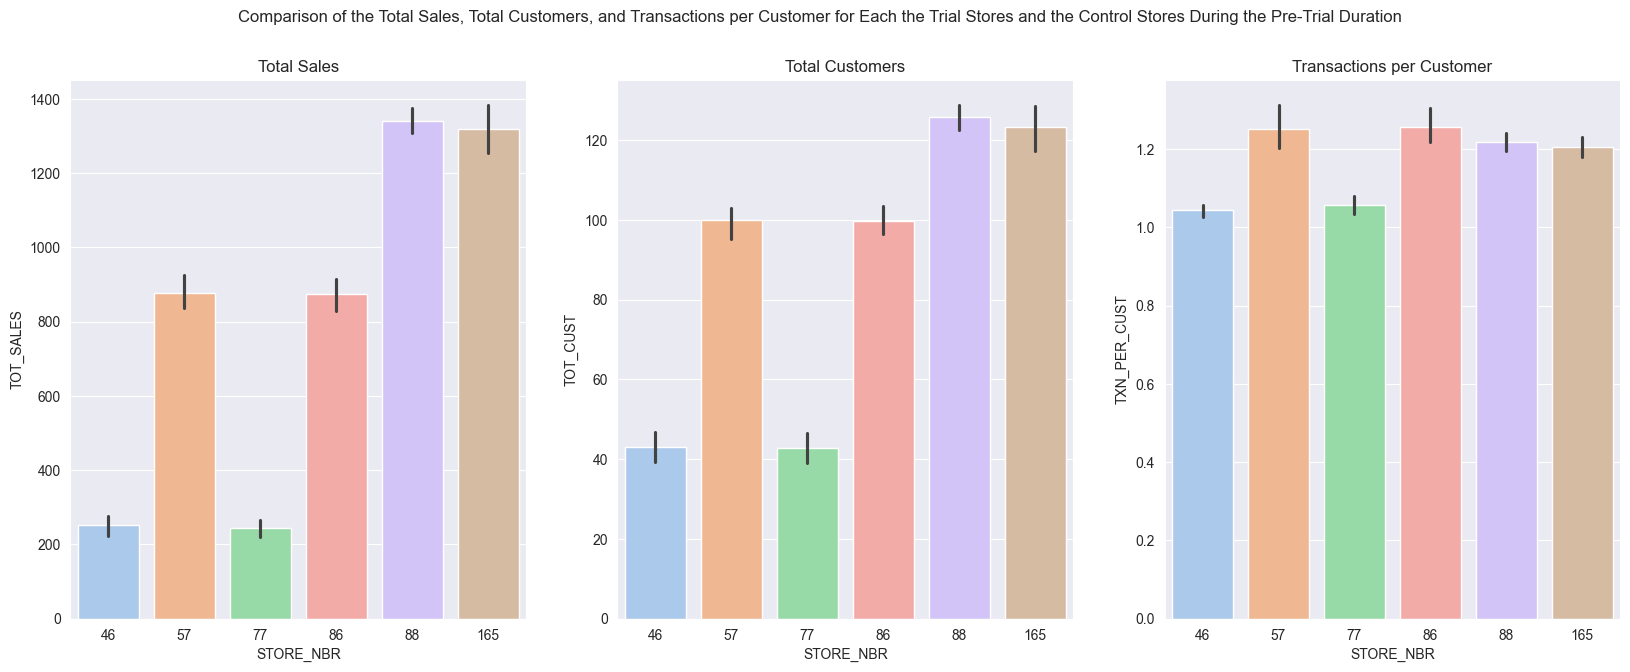

In [39]:
#   Plotting the bar graphs for the total sales, total customers, and transactions per customer for each of the trial stores and the control stores.

sns.set_style("darkgrid")
figure, axis=plt.subplots(1, 3, figsize=(20, 7))
sns.barplot(x="STORE_NBR", y="TOT_SALES", data=stores, ax=axis[0], palette="pastel")
axis[0].set_title("Total Sales")
sns.barplot(x="STORE_NBR", y="TOT_CUST", data=stores, ax=axis[1], palette="pastel")
axis[1].set_title("Total Customers")
sns.barplot(x="STORE_NBR", y="TXN_PER_CUST", data=stores, ax=axis[2], palette="pastel")
axis[2].set_title("Transactions per Customer")
figure.suptitle("Comparison of the Total Sales, Total Customers, and Transactions per Customer for Each the Trial Stores and the Control Stores During the Pre-Trial Duration")
plt.show()

While the other trial stores performed the same as their corresponding control stores, we can see, however, that `STORE_NBR 88` slightly out-performed its control store in all attributes. We can also notice that `STORE_NBR 86 and 88` show a significant difference in terms of the total sales, but this isn't the case with `STORE_NBR 77`, whose sales are considerably less.

Likewise, we can also compare different control stores to each of the trial stores during the trial duration, as well, to find if the total sales are significantly different in the trial duration.

In [40]:
trial_data = df_metrics.loc[df_metrics.index.get_level_values("MONTH-YEAR")>="2019-02"]  #   Extracting the pandas.DataFrame for the trial duration.
trial_data = trial_data.reset_index()
trial_data

,STORE_NBR,MONTH-YEAR,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,1,2019-02,225.4,52,1.057692
1,1,2019-03,192.9,45,1.088889
2,1,2019-04,192.9,42,1.023810
3,1,2019-05,221.4,46,1.108696
4,1,2019-06,174.1,42,1.000000
...,...,...,...,...,...
1295,272,2019-02,395.5,45,1.066667
1296,272,2019-03,442.3,50,1.060000
1297,272,2019-04,445.1,54,1.018519
1298,272,2019-05,314.6,34,1.176471


In [41]:
#   Extracting the pandas.DataFrames for each of the trial stores.

trial_stores_one = trial_data.loc[trial_data.STORE_NBR.isin([77])].reset_index()
trial_stores_two = trial_data.loc[trial_data.STORE_NBR.isin([86])].reset_index()
trial_stores_three = trial_data.loc[trial_data.STORE_NBR.isin([88])].reset_index()

In [42]:
#   Extracting the pandas.DataFrames for each of the control stores.

control_stores_one=trial_data.loc[trial_data.STORE_NBR.isin([46])].reset_index()
control_stores_two=trial_data.loc[trial_data.STORE_NBR.isin([57])].reset_index()
control_stores_three=trial_data.loc[trial_data.STORE_NBR.isin([165])].reset_index()

In [43]:
stores = pd.concat([trial_stores_one, trial_stores_two, trial_stores_three, control_stores_one, control_stores_two, control_stores_three], axis=0)    #   Concatenating all the pandas.DataFrames into one.
stores

,index,STORE_NBR,MONTH-YEAR,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,360,77,2019-02,235.00,45,1.000000
1,361,77,2019-03,278.50,50,1.100000
2,362,77,2019-04,263.50,47,1.021277
3,363,77,2019-05,299.30,55,1.018182
4,364,77,2019-06,264.70,41,1.024390
0,400,86,2019-02,913.20,107,1.289720
1,401,86,2019-03,1026.80,115,1.217391
2,402,86,2019-04,848.20,105,1.200000
3,403,86,2019-05,889.30,104,1.230769
4,404,86,2019-06,838.00,98,1.204082


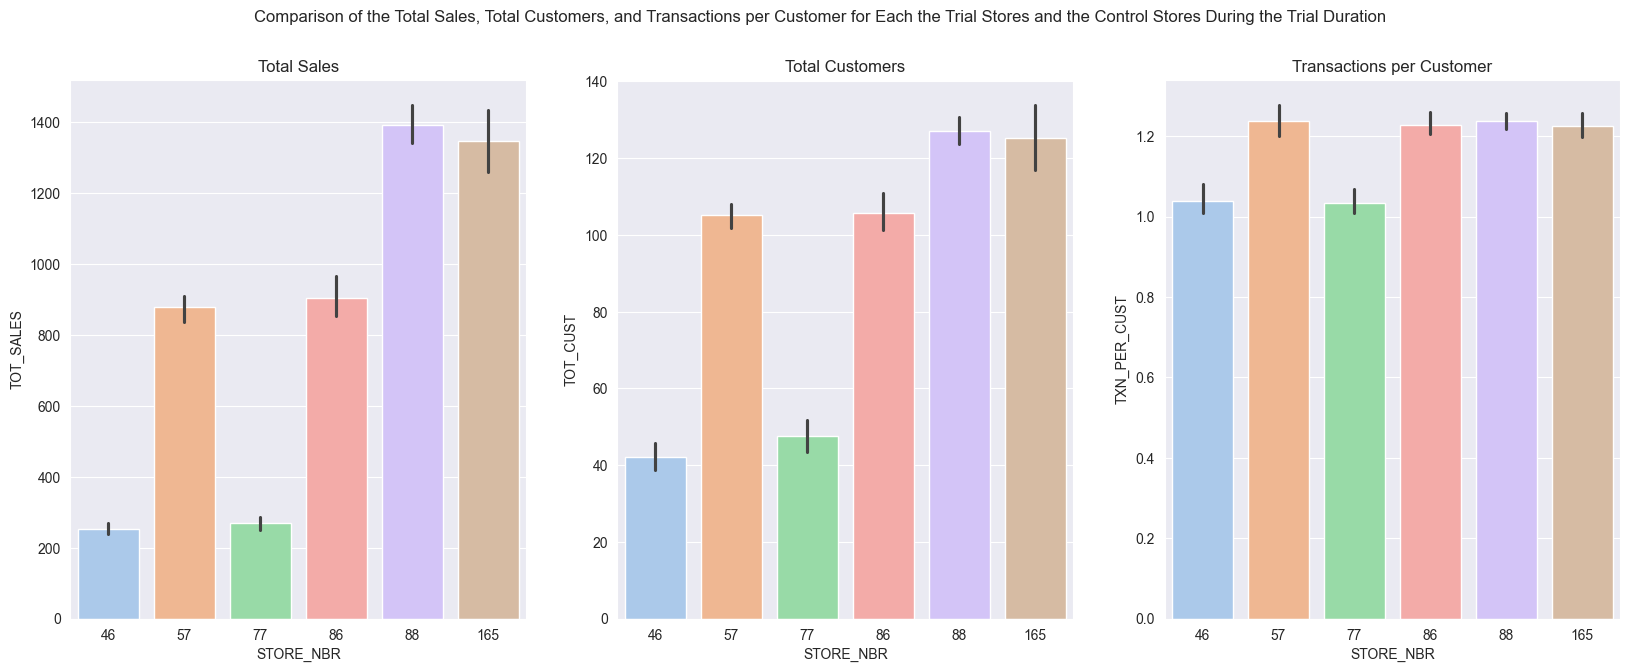

In [44]:
#   Plotting the bar graphs for the total sales, total customers, and transactions per customer for each of the trial stores and the control stores.

sns.set_style("darkgrid")
figure, axis=plt.subplots(1, 3, figsize=(20, 7))
sns.barplot(x="STORE_NBR", y="TOT_SALES", data=stores, ax=axis[0], palette="pastel")
axis[0].set_title("Total Sales")
sns.barplot(x="STORE_NBR", y="TOT_CUST", data=stores, ax=axis[1], palette="pastel")
axis[1].set_title("Total Customers")
sns.barplot(x="STORE_NBR", y="TXN_PER_CUST", data=stores, ax=axis[2], palette="pastel")
axis[2].set_title("Transactions per Customer")
figure.suptitle("Comparison of the Total Sales, Total Customers, and Transactions per Customer for Each the Trial Stores and the Control Stores During the Trial Duration")
plt.show()

### Summary:

- `Store 88` outperforms its control store (Store 165) mainly due to a higher number of customers.

- The increase in total sales is closely tied to the increase in the number of customers rather than the number of transactions per customer.

- The high number of transactions per customer observed in all trial stores indicates that while customers are buying frequently, the key factor driving the increased sales is the larger customer base.

### Overall Insight:

The trial positively impacted all trial stores, primarily through attracting more customers. `Store 88` was the most successful, driven by increased customer numbers. The methodology for selecting control stores using Pearson correlations and a custom metric proved effective.
